# Imports and loads

In [15]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores.csv', encoding='utf-8')

# Preprocess

## Tratando as minutagens

In [16]:
df = df05ht.copy()
print(f'Valores únicos de minutos antes da conversão: {df.minute.unique()} \n')

# Convertendo os minutos para inteiros
df['minute'] = df['minute'].str.extract('(\d+)').astype(int)

print(f'Valores únicos de minutos após a conversão: {df.minute.unique()} \n')

# Removendo os minutos iguais a 0
df = df[df['minute'] != 0]

# Identificando e removendo IDs de jogos com minutos fora do intervalo permitido
invalid_ids = df[df['minute'] > 45]['match_id'].unique()
df = df[~df['match_id'].isin(invalid_ids)]

print(f'Dimensão do DataFrame após remoção: {df.shape}')


Valores únicos de minutos antes da conversão: ['0:53' '2:00' '3:07' ... '45+3:18' '45+5:15' '45+6:44'] 

Valores únicos de minutos após a conversão: [ 0  2  3  4  5  6  7  8  9 10 12 13 14 15 16  1 11 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44 45 40 71 90
 67 68 69] 

Dimensão do DataFrame após remoção: (280498, 27)


In [17]:
# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = (df['passes_away'] / total_passes) * 100
df['possessiontime_home'] = (df['passes_home'] / total_passes) * 100

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)

# Atualizando a coluna 'result' para 0, exceto onde já é 1
df.loc[df['result'] != 1, 'result'] = 0

# Removendo duplicatas com base em 'match_id' e 'minute'
df.drop_duplicates(subset=['match_id', 'minute'], keep='last', inplace=True)

# Classificando o DataFrame
df.sort_values(by=['match_id', 'minute'], inplace=True)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away']
df.drop(columns=columns_to_drop, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Obtendo ligas únicas
leagues_opta = df['league'].unique()

# df.to_csv('data_teste.csv', index=False)

## Tratando o formato das ligas para ligas legíveis na API

In [18]:
for league in leagues_opta:
    print(league)

name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Romania - Supercupa': 'Romania - Super Cup',
    'Romania - Play-offs 1/2': 'Romania - Liga 1 - Play-offs',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', #* grupos f,j...
    'South America - CONMEBOL Sudamericana': 'South America - CONMEBOL Sudamericana', # nao tem
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'South America - CONMEBOL World Cup Qualifiers', # nao tem
    'Europe - UEFA World Cup Qualifiers': 'Europe - UEFA World Cup Qualifiers', # nao tem
    "Europe - UEFA Women's Championship": 'Europe - UEFA Women Championship', # nao tem
    "France - Trophée des Champions": 'France - Trophée des Champions',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',


}

print(len(name_mapping))
print(len(leagues_opta))

# Atualize os nomes das ligas em df05ht
df['league'] = df['league'].replace(name_mapping)


South America - CONMEBOL Libertadores
Brazil - Paulista A1
Asia - AFC Champions League
Brazil - Supercopa do Brasil
Japan - J1 League
South America - CONMEBOL Sudamericana
USA - MLS
Brazil - Copa do Brasil
Germany - Play-offs 1/2
Mexico - Liga MX
Scotland - Premiership
Brazil - Serie A
France - Ligue 1
Europe - UEFA Champions League
England - League Cup
Europe - UEFA Nations League
England - Premier League
Germany - Bundesliga
Italy - Serie A
Italy - Serie B
Netherlands - Eredivisie
England - Championship
Spain - Primera División
Greece - Super League 1
South America - CONMEBOL World Cup Qualifiers
England - League One
England - League Two
Europe - UEFA Europa League
Argentina - Liga Profesional Argentina
England - FA Cup
Australia - A-League Men
Europe - UEFA European Championship
N/C America - Concacaf Gold Cup
Europe - UEFA World Cup Qualifiers
Denmark - Superliga
Saudi Arabia - Saudi League
Italy - Coppa Italia
Romania - Liga I
Spain - Segunda División
Germany - DFB Pokal
Portugal 

In [19]:
print(len(df['match_id'].unique()))
print(df['result'].value_counts())
print(len(df))

6543
0.0    155962
1.0     15155
Name: result, dtype: int64
171117


In [20]:
# Counting the number of matches played by each team
matches_home = df['homeTeam'].value_counts()
matches_away = df['awayTeam'].value_counts()

# Combining home and away matches for each team
total_matches_per_team = matches_home.add(matches_away, fill_value=0)

# Checking if each team has played at least 100 matches
teams_with_100_plus_matches = total_matches_per_team[total_matches_per_team >= 100]

# Analyzing the distribution of values in the 'result' column
result_distribution = df05ht['result'].value_counts(normalize=True)

teams_with_100_plus_matches, result_distribution


(1. FC Heidenheim 1846          194.0
 1. FC Köln                     782.0
 1. FC Union Berlin            1517.0
 1. FSV Mainz 05               1086.0
 AC Ajaccio                     513.0
                                ...  
 Wolverhampton Wanderers FC    2295.0
 Wrexham FC                     135.0
 Wycombe Wanderers FC           291.0
 Yokohama F. Marinos            197.0
 Yokohama FC                    100.0
 Length: 570, dtype: float64,
 0.0    0.821103
 1.0    0.178897
 Name: result, dtype: float64)

In [21]:
# 1. Identify leagues with only one unique value in 'result' column
single_value_leagues = df.groupby('league').apply(lambda x: len(x['result'].unique()) == 1)

# 2. Identify leagues with fewer than 100 matches
few_matches_leagues = df['league'].value_counts()
few_matches_leagues = few_matches_leagues[few_matches_leagues < 100].index.tolist()

# Combine the lists of leagues to drop
leagues_to_drop = single_value_leagues[single_value_leagues].index.tolist() + few_matches_leagues

# Drop the identified leagues
filtered_data = df[~df['league'].isin(leagues_to_drop)]

# 3. Balance the 'result' column for each remaining league
balanced_data = []
for league in filtered_data['league'].unique():
    league_data = filtered_data[filtered_data['league'] == league]
    min_count = league_data['result'].value_counts().min()
    
    # Sample 'min_count' examples from each result value
    balanced_samples = [league_data[league_data['result'] == result_val].sample(min_count, random_state=42) for result_val in [0, 1]]
    balanced_data.extend(balanced_samples)

# Combine the balanced data samples
balanced_data = pd.concat(balanced_data, axis=0)
balanced_data.dropna(inplace=True)

# Display the first few rows of the balanced data and the list of dropped leagues
leagues_to_drop


['England - Community Shield',
 'Europe - Uefa Super Cup',
 'Germany - Bundesliga Play-offs',
 'Italy - Super Cup',
 'N/C America - Leagues Cup',
 'South America - Recopa Sudamericana',
 'World - FIFA Club World Cup',
 'South America - Recopa Sudamericana',
 'Spain - Super Cup',
 'England - Community Shield',
 'Portugal - Primeira Liga - Play-offs',
 'Brazil - Supercopa do Brasil',
 'Europe - Uefa Super Cup',
 'Germany - Bundesliga Play-offs',
 'Italy - Super Cup',
 'N/C America - Leagues Cup']

In [22]:
df = balanced_data.copy()
df['result'].value_counts()

0.0    15059
1.0    15059
Name: result, dtype: int64

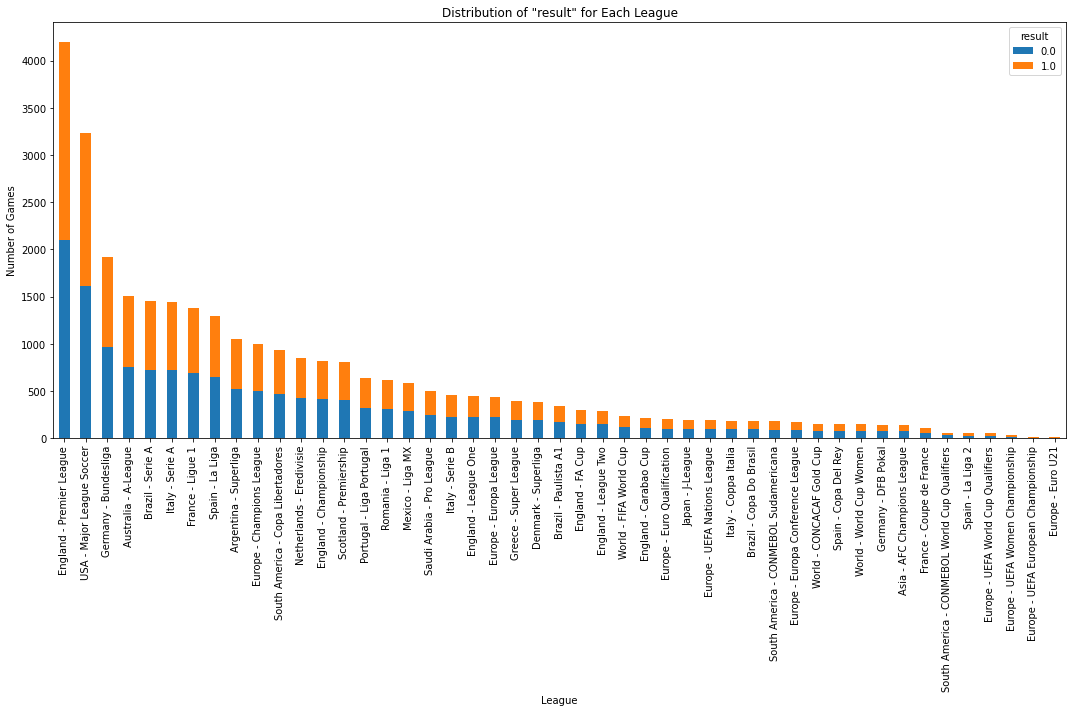

In [23]:
# Group the data by league and result and get the size of each group
league_distribution = df.groupby(['league', 'result']).size().unstack().fillna(0)

# Sort the leagues based on the total number of games
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

# Plot
plt.figure(figsize=(15, 10))
league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribution of "result" for Each League')
plt.ylabel('Number of Games')
plt.xlabel('League')
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()


# Preprocessor Features

In [24]:
# Separando os dados em características e variável alvo
X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
# X = df.drop(columns=['result','league', 'match_id'])
y = df['result']

# Definindo as colunas numéricas e categóricas
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
# categorical_features = ['homeTeam', 'awayTeam']
categorical_features = ['league']

# Criando o transformador de colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Aplicando as transformações
X = preprocessor.fit_transform(X)

with open(f'../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,train_size=0.80, random_state=42)

# Modeling

## Automl h2o

In [26]:
# Inicializar o H2O
h2o.init()

# Convertendo dados do numpy para H2OFrame
X_train_h2o = h2o.H2OFrame(pd.DataFrame(X_train, columns=["col_" + str(i) for i in range(X_train.shape[1])]))
X_test_h2o = h2o.H2OFrame(pd.DataFrame(X_test, columns=["col_" + str(i) for i in range(X_test.shape[1])]))
y_train_h2o = h2o.H2OFrame(pd.DataFrame(y_train, columns=["result"]))
y_test_h2o = h2o.H2OFrame(pd.DataFrame(y_test, columns=["result"]))

# Convert Pandas DataFrame or NumPy array to H2OFrame
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)

y_train_df = y_train.to_frame()
y_train_h2o = h2o.H2OFrame(y_train_df)
y_train_h2o['result'] = y_train_h2o['result'].asfactor()

y_test_df = y_test.to_frame()
y_test_h2o = h2o.H2OFrame(y_test_df)
y_test_h2o['result'] = y_test_h2o['result'].asfactor()

# Check the shape again
print("X_train_h2o shape:", X_train_h2o.shape)
print("y_train_h2o shape:", y_train_h2o.shape)
print("X_test_h2o shape:", X_test_h2o.shape)
print("y_test_h2o shape:", y_test_h2o.shape)

# Combine them back into one frame
train_data = X_train_h2o.cbind(y_train_h2o)
test_data = X_test_h2o.cbind(y_test_h2o)

# Identify predictors and response
x = train_data.columns

y = "result"
x.remove(y)

# Run AutoML
aml = H2OAutoML(max_models=20, seed=42)
aml.train(x=x, y=y, training_frame=train_data)

# View leaderboard
lb = aml.leaderboard
print(lb)

#save the model
model_path = h2o.save_model(model=aml.leader, path="../models/", force=True)

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 mins 26 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,2 months and 26 days
H2O_cluster_name:,H2O_from_python_Pichau_0llkz7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.965 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
X_train_h2o shape: (24094, 65)
y_train_h2o shape: (24094, 1)
X_test_h2o shape: (6024, 65)
y_test_h2o shape: (6024, 1)
AutoML progress: |█
12:30:54.139: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


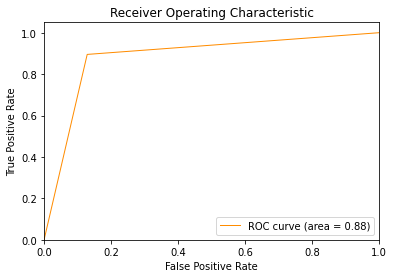

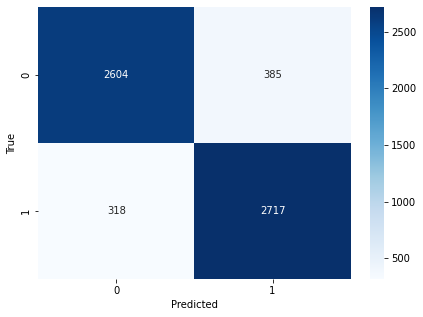

In [33]:
loaded_model = h2o.load_model("C:/Users/Pichau/Desktop/eofut/models/model_automl")
y_pred_prob = loaded_model.predict(X_test_h2o)
y_pred = h2o.as_list(y_pred_prob)
y_pred_prob = y_pred['predict'].tolist()

# Falsos positivos, verdadeiros positivos e limiares
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Área sob a curva
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusão
y_pred_round = [round(value) for value in y_pred_prob]
cm = confusion_matrix(y_test.to_list(), y_pred_round)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### In pratice

In [31]:
# h2o.init()
loaded_model = h2o.load_model("C:/Users/Pichau/Desktop/eofut/models/model_automl")
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
Xht = h2o.H2OFrame(Xht)
loaded_model.predict(Xht)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.0241045,0.975896


In [34]:
h2o.as_list(loaded_model.predict(Xht)).loc[0, 'p1']

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


0.975895507541737

## Random Forest

In [35]:
# teste com random forest foi feito mas não atingiu uma boa espectativa 
# # Criando o modelo base
# rfc = RandomForestClassifier(n_estimators=1000,max_depth=40, min_samples_leaf=1, min_samples_split=30, max_features=None, random_state=1, n_jobs=-1)

# import accuracy_score
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=100)

# # # Treinando o modelo com os melhores hiperparâmetros
rfc.fit(X_train, y_train)

predictions = rfc.predict(X_test)
accuracy = accuracy_score(y_test, predictions)


print(f" Teste Acurácia do modelo Random Forest: {accuracy * 100:.2f}%")
print(f"Erro quadrático médio: {mean_squared_error(y_test, predictions)}")
print(f"Treino Acurácia do modelo Random Forest: {rfc.score(X_train, y_train) * 100:.2f}%")

with open(f'random_forestht.pkl', 'wb') as f:
    pickle.dump(rfc, f)

 Teste Acurácia do modelo Random Forest: 89.72%
Erro quadrático médio: 0.10275564409030545
Treino Acurácia do modelo Random Forest: 99.97%


## Neural Network Keras

In [36]:
# X_train = X_train.toarray()
# X_test = X_test.toarray()

Epoch 1/500
377/377 [==============================] - 1s 2ms/step - loss: 0.6863 - accuracy: 0.5448 - recall: 0.5436 - val_loss: 0.6806 - val_accuracy: 0.5647 - val_recall: 0.5124
Epoch 2/500
377/377 [==============================] - 1s 1ms/step - loss: 0.6666 - accuracy: 0.5954 - recall: 0.5943 - val_loss: 0.6651 - val_accuracy: 0.6013 - val_recall: 0.6570
Epoch 3/500
377/377 [==============================] - 1s 1ms/step - loss: 0.6461 - accuracy: 0.6273 - recall: 0.6278 - val_loss: 0.6516 - val_accuracy: 0.6155 - val_recall: 0.6392
Epoch 4/500
377/377 [==============================] - 0s 1ms/step - loss: 0.6217 - accuracy: 0.6535 - recall: 0.6559 - val_loss: 0.6449 - val_accuracy: 0.6243 - val_recall: 0.5493
Epoch 5/500
377/377 [==============================] - 0s 1ms/step - loss: 0.5962 - accuracy: 0.6788 - recall: 0.6781 - val_loss: 0.6161 - val_accuracy: 0.6614 - val_recall: 0.6913
Epoch 6/500
377/377 [==============================] - 0s 1ms/step - loss: 0.5693 - accuracy: 0

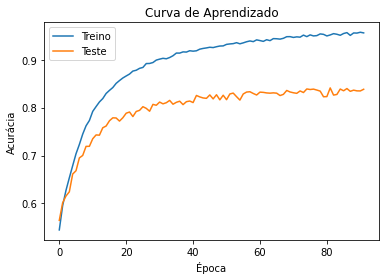

In [37]:
predictions = []
  
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
# model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))  # Binary classification


# Compilando o modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy', 'Recall'])




early_stop = EarlyStopping(monitor='val_loss', patience=50)

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)
# history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=1)



# Faz a predição utilizando os dados de teste
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

# Avaliando a acurácia do modelo no conjunto de treinamento e conjunto de teste
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy on training set:', train_acc)
print('Accuracy on test set:', test_acc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

# save model .h5
model.save('model_redeht.h5')

In [38]:
# Predict with model generation gan

